In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

# Hyperparameter optimization

This notebook was made with the following version of george:

In [2]:
import george
george.__version__

'1.0.0.dev0'

In this tutorial, we’ll reproduce the analysis for Figure 5.6 in [Chapter 5 of Rasmussen & Williams (R&W)](http://www.gaussianprocess.org/gpml/chapters/RW5.pdf). The data are measurements of the atmospheric CO2 concentration made at Mauna Loa, Hawaii (Keeling & Whorf 2004). The dataset is said to be available online but I couldn’t seem to download it from the original source. Luckily the [statsmodels](http://statsmodels.sourceforge.net/) package [includes a copy](http://statsmodels.sourceforge.net/devel/datasets/generated/co2.html) that we can load as follows: 

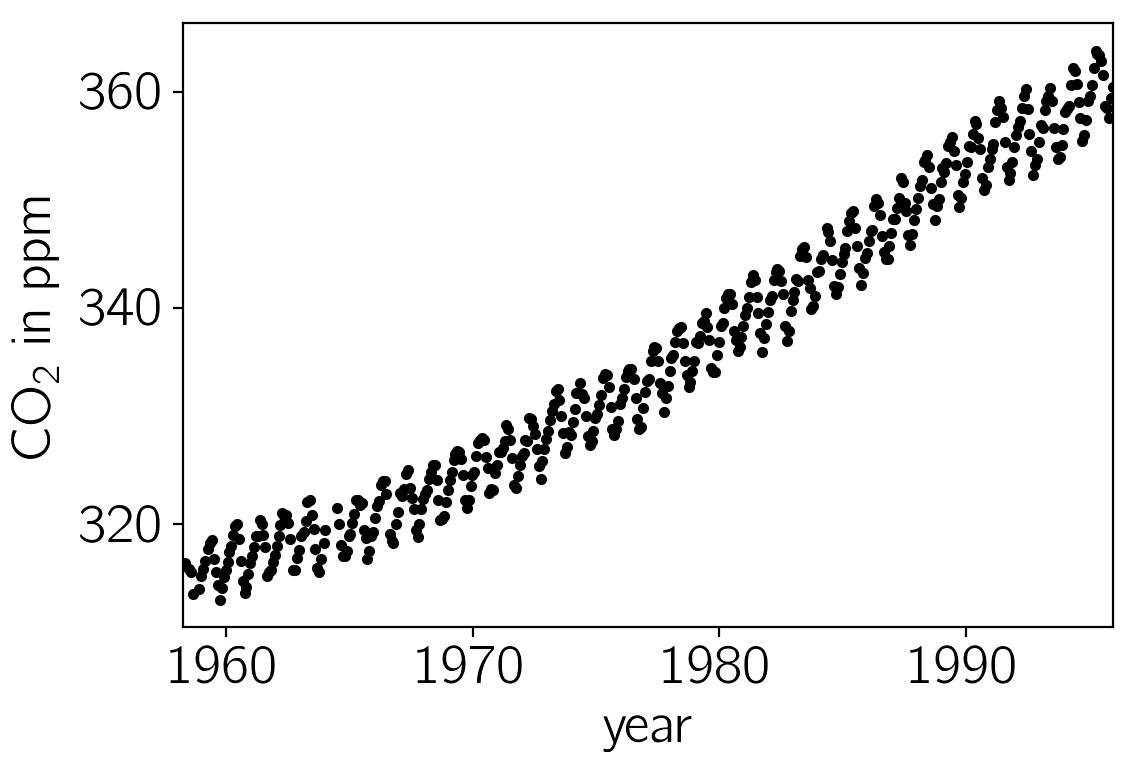

In [49]:
import numpy as np
import matplotlib.pyplot as pl
from statsmodels.datasets import co2

data = co2.load_pandas().data
t = 2000 + (np.array(data.index.to_julian_date()) - 2451545.0) / 365.25
y = np.array(data.co2)
m = np.isfinite(t) & np.isfinite(y) & (t < 1996)
t, y = t[m][::4], y[m][::4]

pl.plot(t, y, ".k")
pl.xlim(t.min(), t.max())
pl.xlabel("year")
pl.ylabel("CO$_2$ in ppm");

In this figure, you can see that there is periodic (or quasi-periodic) signal with a year-long period superimposed on a long term trend. We will follow R&W and model these effects non-parametrically using a complicated covariance function. The covariance function that we’ll use is:

$$k(r) = k_1(r) + k_2(r) + k_3(r) + k_4(r)$$

where

$$
\begin{eqnarray}
    k_1(r) &=& \theta_1^2 \, \exp \left(-\frac{r^2}{2\,\theta_2} \right) \\
    k_2(r) &=& \theta_3^2 \, \exp \left(-\frac{r^2}{2\,\theta_4}
                                         -\theta_5\,\sin^2\left(
                                         \frac{\pi\,r}{\theta_6}\right)
                                        \right) \\
    k_3(r) &=& \theta_7^2 \, \left [ 1 + \frac{r^2}{2\,\theta_8\,\theta_9}
                             \right ]^{-\theta_8} \\
    k_4(r) &=& \theta_{10}^2 \, \exp \left(-\frac{r^2}{2\,\theta_{11}} \right)
                + \theta_{12}^2\,\delta_{ij}
\end{eqnarray}
$$

We can implement this kernel in George as follows (we'll use the R&W results
as the hyperparameters for now):

In [50]:
from george import kernels

k1 = 66**2 * kernels.ExpSquaredKernel(metric=67**2)
k2 = 2.4**2 * kernels.ExpSquaredKernel(90**2) * kernels.ExpSine2Kernel(gamma=2/1.3**2, log_period=0.0)
k3 = 0.66**2 * kernels.RationalQuadraticKernel(log_alpha=np.log(0.78), metric=1.2**2)
k4 = 0.18**2 * kernels.ExpSquaredKernel(1.6**2)
kernel = k1 + k2 + k3 + k4

## Optimization

If we want to find the "best-fit" hyperparameters, we should *optimize* an objective function.
The two standard functions (as described in Chapter 5 of R&W) are the marginalized ln-likelihood and the cross validation likelihood.
George implements the former in the ``GP.lnlikelihood`` function and the gradient with respect to the hyperparameters in the ``GP.grad_lnlikelihood`` function:

In [51]:
import george
gp = george.GP(kernel, mean=np.mean(y), fit_mean=True,
               white_noise=np.log(0.19**2), fit_white_noise=True)
gp.compute(t)
print(gp.log_likelihood(y))
print(gp.grad_log_likelihood(y))

-608.938634448
[  1.20325990e-02   5.65011826e+02   4.94824766e-02  -1.20640197e+00
   3.33835864e+00   2.43343814e-01   7.10415081e+00  -5.38311429e+03
   1.96801995e+01  -2.05383850e+01  -5.36816015e+01  -1.32619973e-02
  -6.14334711e-03]


We'll use a gradient based optimization routine from SciPy to fit this model as follows:

In [52]:
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(y, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(t)

# Print the initial ln-likelihood.
print(gp.log_likelihood(y))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(y))

-608.938634448
-297.39949848


**Warning:** *An optimization code something like this should work on most problems but the results can be very sensitive to your choice of initialization and algorithm. If the results are nonsense, try choosing a better initial guess or try a different value of the ``method`` parameter in ``op.minimize``.*

We can plot our prediction of the CO2 concentration into the future using our optimized Gaussian process model by running:

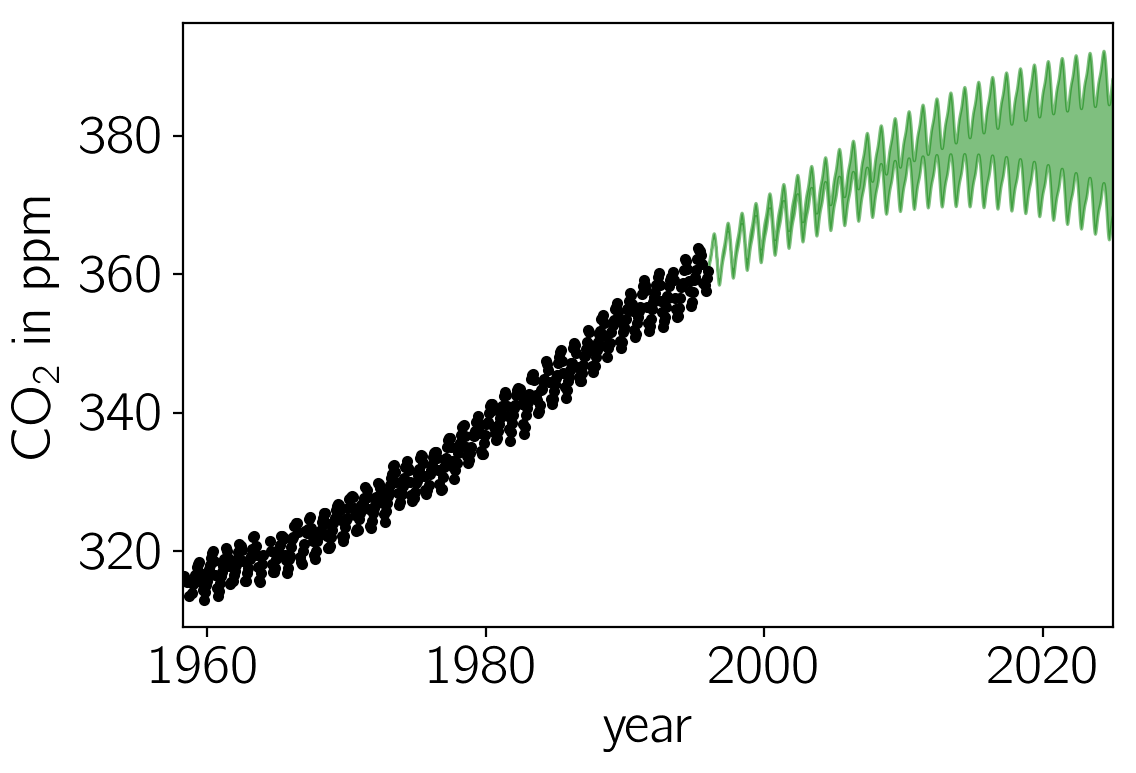

In [54]:
x = np.linspace(max(t), 2025, 2000)
mu, var = gp.predict(y, x, return_var=True)
std = np.sqrt(var)

pl.plot(t, y, ".k")
pl.fill_between(x, mu+std, mu-std, color="g", alpha=0.5)

pl.xlim(t.min(), 2025)
pl.xlabel("year")
pl.ylabel("CO$_2$ in ppm");

## Sampling & Marginalization

The prediction made in the previous section take into account uncertainties due to the fact that a Gaussian process is stochastic but it doesn’t take into account any uncertainties in the values of the hyperparameters. This won’t matter if the hyperparameters are very well constrained by the data but in this case, many of the parameters are actually poorly constrained. To take this effect into account, we can apply prior probability functions to the hyperparameters and marginalize using Markov chain Monte Carlo (MCMC). To do this, we’ll use the [emcee](http://dfm.io/emcee) package.

First, we define the probabilistic model:

In [55]:
def lnprob(p):
    # Trivial uniform prior.
    if np.any((-100 > p[1:]) + (p[1:] > 100)):
        return -np.inf

    # Update the kernel and compute the lnlikelihood.
    gp.set_parameter_vector(p)
    return gp.lnlikelihood(y, quiet=True)

In this function, we’ve applied a prior on every parameter that is uniform between -100 and 100 for every parameter. In real life, you should probably use something more intelligent but this will work for this problem. The quiet argument in the call to ``GP.lnlikelihood()`` means that that function will return ``-numpy.inf`` if the kernel is invalid or if there are any linear algebra errors (otherwise it would raise an exception).

Then, we run the sampler (this will probably take a while to run if you want to repeat this analysis): 

In [56]:
import emcee

gp.compute(t)

# Set up the sampler.
nwalkers, ndim = 36, len(gp)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Initialize the walkers.
p0 = gp.get_parameter_vector() + 1e-4 * np.random.randn(nwalkers, ndim)

print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, 200)

print("Running production chain")
sampler.run_mcmc(p0, 200);

Running burn-in
Running production chain


After this run, you can plot 50 samples from the marginalized predictive probability distribution:

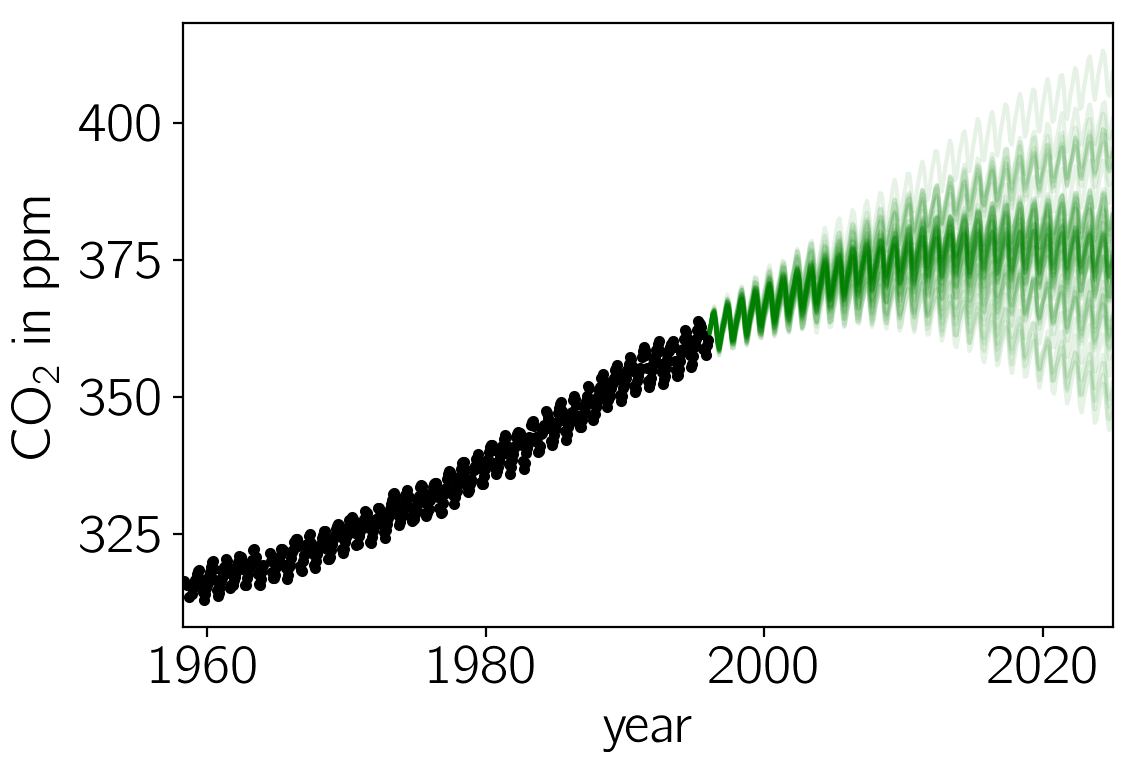

In [58]:
x = np.linspace(max(t), 2025, 250)
for i in range(50):
    # Choose a random walker and step.
    w = np.random.randint(sampler.chain.shape[0])
    n = np.random.randint(sampler.chain.shape[1])
    gp.set_parameter_vector(sampler.chain[w, n])

    # Plot a single sample.
    pl.plot(x, gp.sample_conditional(y, x), "g", alpha=0.1)
    
pl.plot(t, y, ".k")

pl.xlim(t.min(), 2025)
pl.xlabel("year")
pl.ylabel("CO$_2$ in ppm");

Comparing this to the same figure in the previous section, you’ll notice that the error bars on the prediction are now substantially larger than before. This is because we are now considering all the predictions that are consistent with the data, not just the “best” prediction. In general, even though it requires much more computation, it is more conservative (and honest) to take all these sources of uncertainty into account.